In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
from pymc3.backends import Text
import matplotlib.pyplot as plt
import re

%matplotlib inline

## Pre-Processing

In [2]:
# Import season 2013/14 fixtures
df = pd.read_csv('./data/ts14-15.csv')
df = df.drop('Unnamed: 0', 1)

# Build team index
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

df = df.sort_values(by='kick_off', ascending=1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

# Add back to back fixture round index t
fixtures_per_round = num_teams/2
num_rounds = 38

rounds = np.array([[x]*(fixtures_per_round) for x in range(1,39)]).flatten()
df['t'] = 1
df['t'] = rounds

T = observed_home_goals.shape[0]

df[1:19]

home_score  away_score    kick_off             home_team  \
56            1           2  2014-08-16     Manchester United   
274           0           1  2014-08-16       West Ham United   
10            2           1  2014-08-16               Arsenal   
340           0           1  2014-08-16   Queens Park Rangers   
235           2           2  2014-08-16        Leicester City   
202           2           2  2014-08-16  West Bromwich Albion   
62            2           1  2014-08-17             Liverpool   
84            0           2  2014-08-17      Newcastle United   
305           1           3  2014-08-18               Burnley   
377           1           0  2014-08-23          Swansea City   
222           1           3  2014-08-23        Crystal Palace   
30            2           0  2014-08-23               Chelsea   
133           2           2  2014-08-23               Everton   
123           0           0  2014-08-23           Southampton   
99            0           0  2014-08-23           Aston Villa   
168           4           0  2014-08-24     Tottenham Hotspur   
249           1           1  2014-08-24            Sunderland   
357           1           1  2014-08-24             Hull City   

                away_team  i_home  i_away  t  
56           Swansea City       2      19  1  
274     Tottenham Hotspur      14       8  1  
10         Crystal Palace       0      11  1  
340             Hull City      17      18  1  
235               Everton      12       7  1  
202            Sunderland      10      13  1  
62            Southampton       3       6  1  
84        Manchester City       4       9  1  
305               Chelsea      16       1  1  
377               Burnley      19      16  2  
222       West Ham United      11      14  2  
30         Leicester City       1      12  2  
133               Arsenal       7       0  2  
123  West Bromwich Albion       6      10  2  
99       Newcastle United       5       4  2  
168   Queens Park Rangers       8      17  2  
249     Manchester United      13       2  2  
357            Stoke City      18      15  2

## Model Definition

In [305]:
trace_len = 10000
num_weeks = 38

models = []

# If run with T == 1, only fit timestep 1 without AR
for t in range(1,num_weeks+1):
    print "\nTrain week %d of %d (i=%d)" %(t, num_weeks, t)

    with pm.Model() as exp_1:    
        # global model parameters
        home = pm.Normal('home', mu=0, tau=0.0001)
        tau_att = pm.Gamma('tau_att', alpha=0.1, beta=0.1)
        tau_def = pm.Gamma('tau_def', alpha=0.1, beta=0.1)
        intercept = pm.Normal('intercept', mu=0, tau=0.0001)

        atts_star   = pm.Normal("atts_star",
                               mu = 0,
                               tau = tau_att,
                               shape = num_teams)
        defs_star   = pm.Normal("defs_star",
                               mu = 0,
                               tau = tau_def,
                               shape = num_teams)
        # Identifieability
        atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
        defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
        home_theta  = tt.exp(intercept + home + atts[home_team[:t*10]] + defs[away_team[:t*10]])
        away_theta  = tt.exp(intercept + atts[away_team[:t*10]] + defs[home_team[:t*10]])

        # Likelihood
        home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals[:t*10])
        away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals[:t*10])
        
        models.append(exp_1)
        
        # Sampling
        # If no previous model runs, find map as starting point
        # otherwise use estimates from previous model run
        # No starting point for atts_ni{t+1} and defs respectively, could use atts_ni{t} estimates instead
#         if (t == 1):
#             start = pm.find_MAP()
#         else:
#             tracename = "trace_exp_1_nuts_" + str(t-1)
            
#             print "Load last trace '" + tracename + "'"
            
#             trace_loaded = pm.backends.text.load(tracename)
#             pattern = re.compile("(atts\d|defs\d|.*_ni" + str(t) + ")")
#             start = {key: np.mean(trace_loaded[key], axis=0) for key in trace_loaded.varnames if pattern.match(key) == None}
            
#         # step = pm.NUTS()
#         step = pm.NUTS()
#         db = Text("trace_exp_1_nuts_{0}".format(t))
#         trace = pm.sample(trace_len, step, start=start, trace=db)


Train week 1 of 38 (i=1)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 2 of 38 (i=2)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 3 of 38 (i=3)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 4 of 38 (i=4)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 5 of 38 (i=5)
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.

Train week 6 of 38 (i=6)
Applied log-transform to tau_att and added transformed tau_att_log to mode

## Analyse Convergence

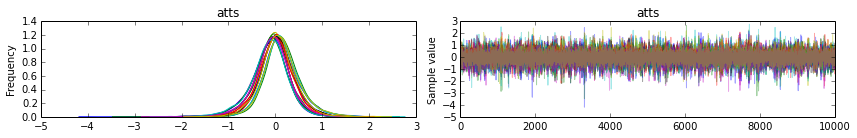

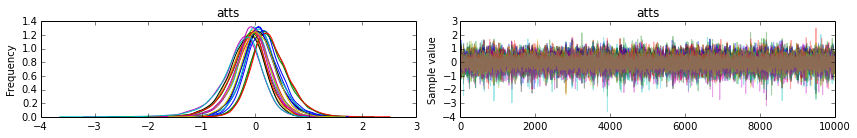

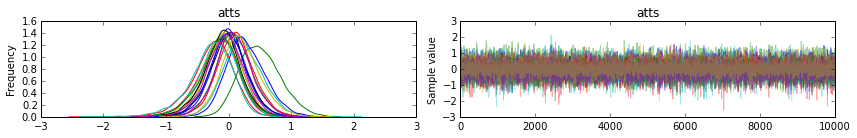

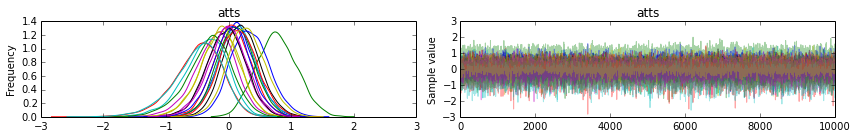

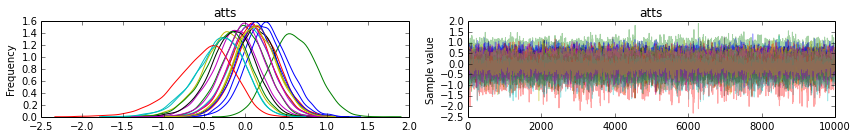

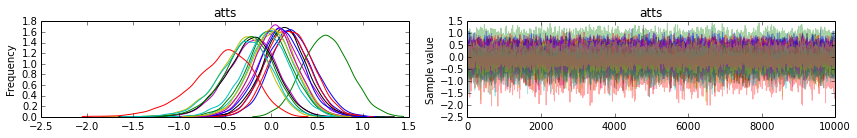

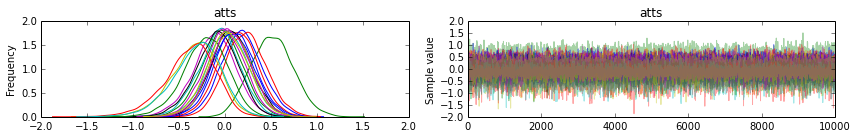

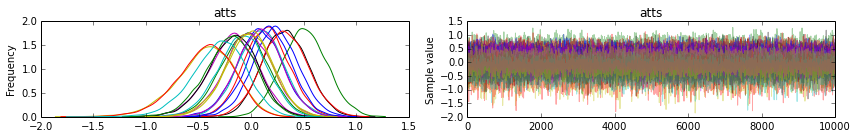

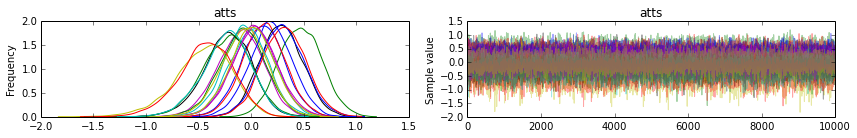

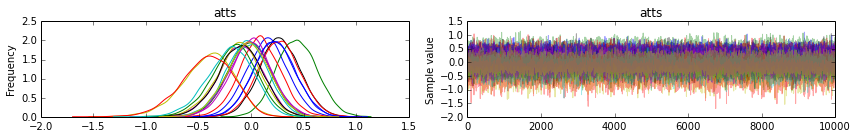

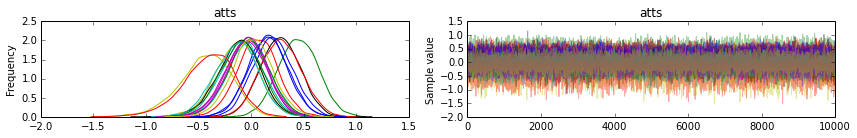

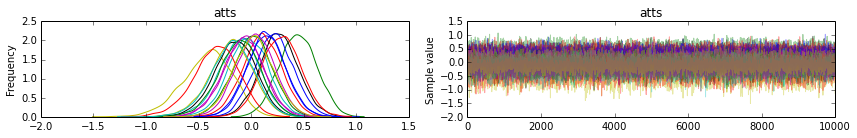

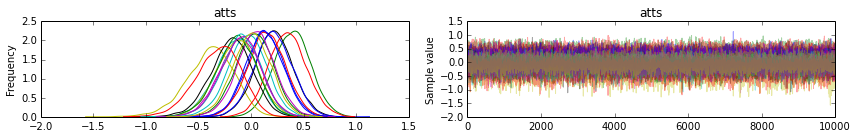

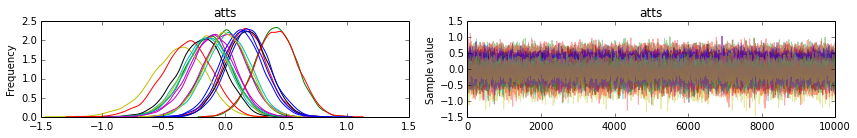

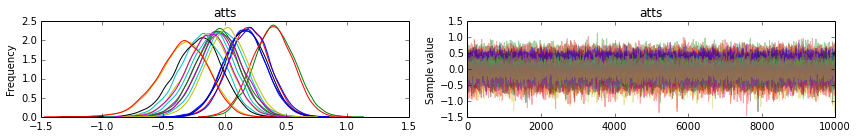

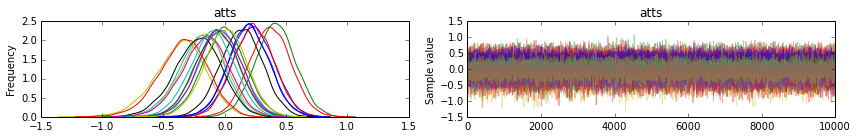

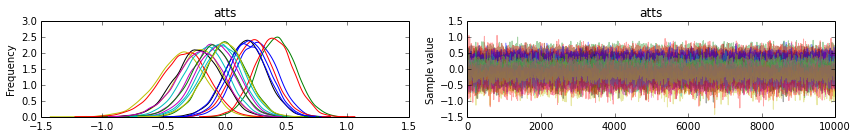

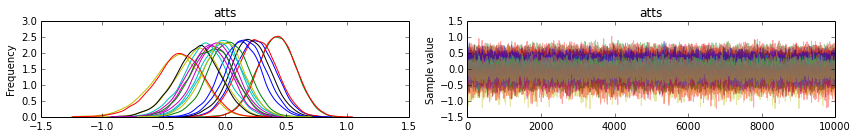

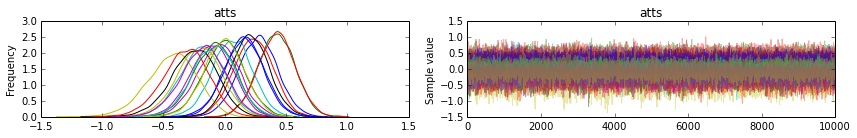

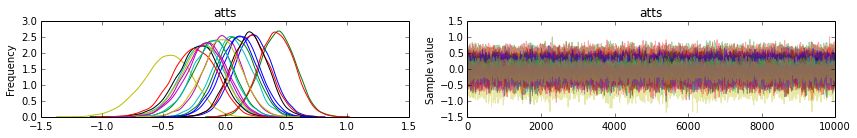

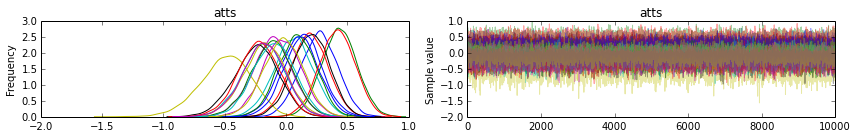

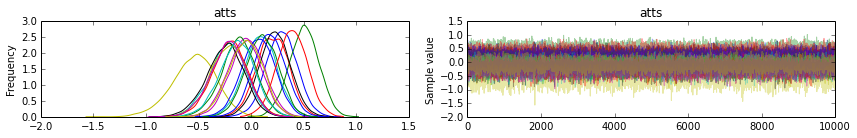

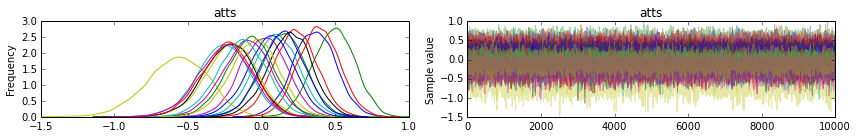

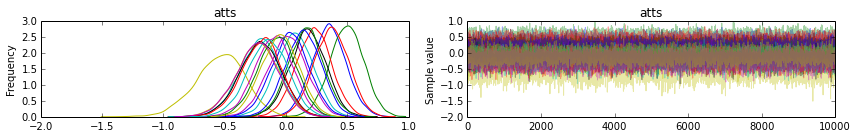

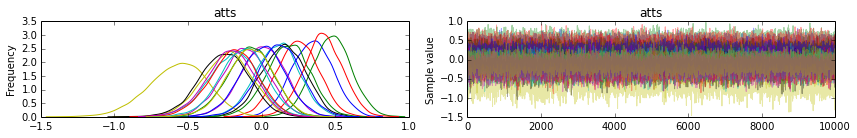

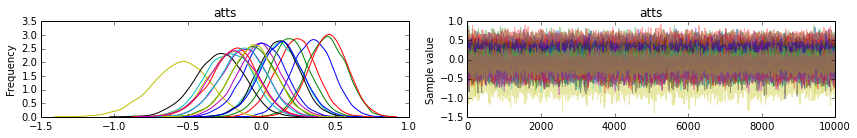

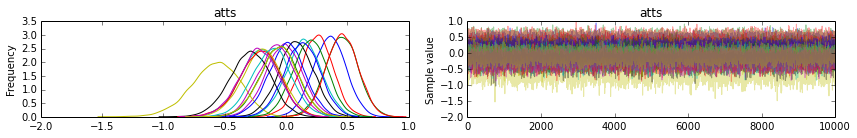

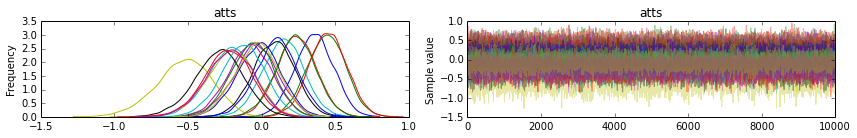

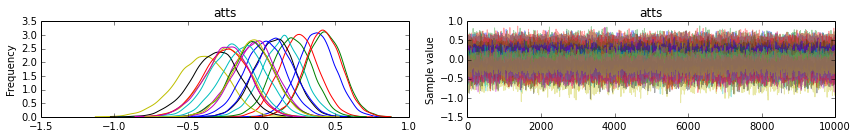

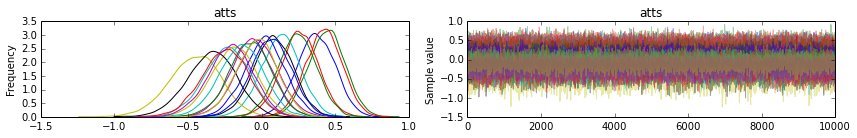

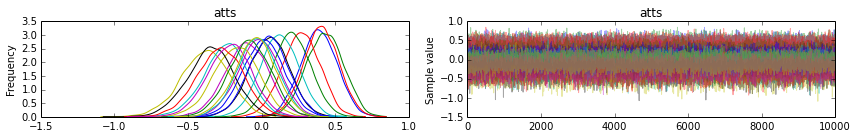

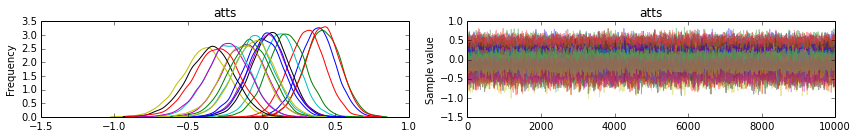

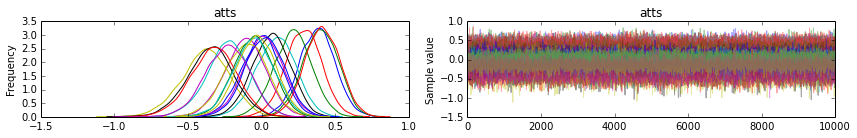

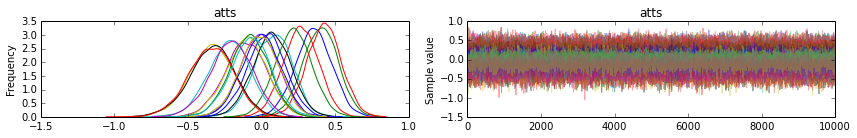

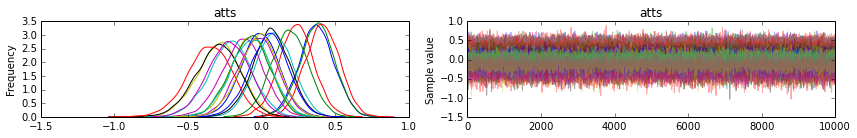

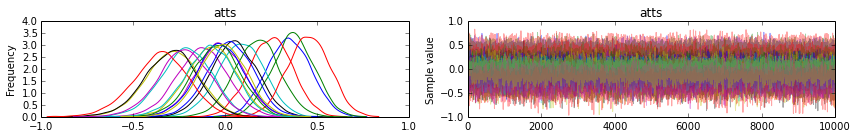

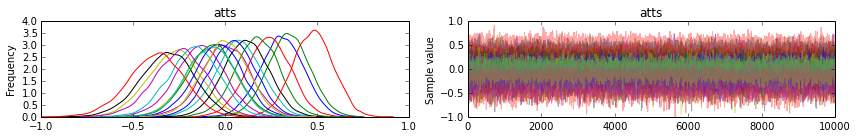

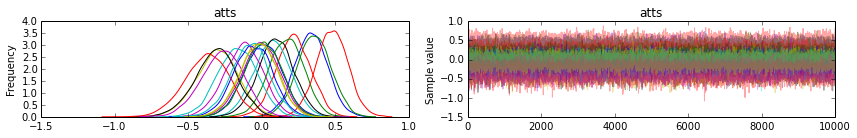

In [306]:
traces = []

for k, m in enumerate(models):
    with m:
        tracename = "/Users/moe/Development/busics/thesis/notebooks/nuts/nuts_trace_exp_1_" + str(k+1)
        trace = pm.backends.text.load(tracename)
        traces.append(trace)
        pm.traceplot(trace, [atts])

## Analyse Autocorrelation

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 0.6116727 ,  0.62505419,  0.638176  ,  0.64606257,  0.66098762,
         0.67665782,  0.70503477,  0.73589901,  0.78001914,  0.83475804,
         1.        ,  0.83475804,  0.78001914,  0.73589901,  0.70503477,
         0.67665782,  0.66098762,  0.64606257,  0.638176  ,  0.62505419,
         0.6116727 ]),
 <matplotlib.lines.Line2D at 0x13c1bea10>)

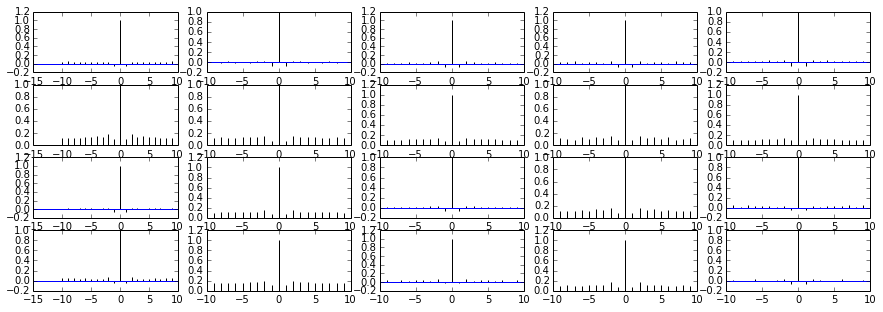

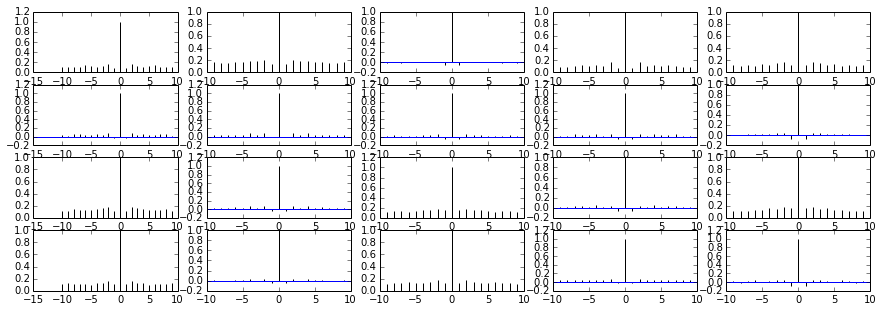

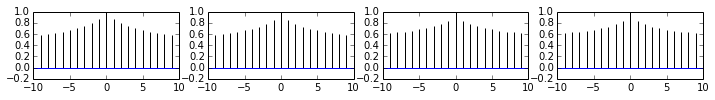

In [370]:
from pandas.tools.plotting import autocorrelation_plot

m = models[0]
t = traces[0]

atts = np.swapaxes(t['atts'],0,1)
defs = np.swapaxes(t['defs'],0,1)
home = t['home']
intercept = t['intercept']
tau_att = t['tau_att']
tau_def = t['tau_def']

fig_att, ax_def = plt.subplots(4,5,figsize=(15,5))
fig_def, ax_att = plt.subplots(4,5,figsize=(15,5))

c = 0
for i in range(0,4):
    for j in range(0,5):
        ax_att[i,j].acorr(atts[c])
        ax_def[i,j].acorr(defs[c])
        c += 1
        
fig_misc, ax_misc = plt.subplots(1,4,figsize=(12,1.2))

ax_misc[0].acorr(home)
ax_misc[1].acorr(intercept)
ax_misc[2].acorr(tau_att)
ax_misc[3].acorr(tau_def)

## Effective Sample Size and other

In [374]:
with m:
    pm.summary(t, varnames=['atts'])


atts:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.131            0.409            0.005            [-0.665, 0.975]
  0.162            0.388            0.005            [-0.634, 0.944]
  0.006            0.397            0.004            [-0.819, 0.772]
  0.129            0.403            0.005            [-0.649, 0.986]
  -0.140           0.413            0.005            [-0.995, 0.635]
  -0.069           0.378            0.004            [-0.855, 0.686]
  -0.072           0.383            0.004            [-0.850, 0.734]
  0.049            0.375            0.004            [-0.698, 0.808]
  -0.062           0.385            0.004            [-0.883, 0.663]
  0.048            0.381            0.004            [-0.713, 0.825]
  0.145            0.400            0.005            [-0.643, 0.976]
  -0.072           0.398            0.004            [-0.926, 0.698]
  0.144            0.

## Predictive Analysis: 1-Step ahead prediction

In [610]:
from scipy.stats import poisson

num_weeks = 38
num_games = num_weeks * 10
ll = 0
ll_hg = 0
ll_ag = 0
act_home_points = []
act_away_points = []
sim_home_points = []
sim_away_points = []

for w in range(0, num_weeks):
    # Get fixtures and trace for week w
    a = away_team[w*10:w*10+10]
    h = home_team[w*10:w*10+10]
    t = traces[w]
    act_home = observed_home_goals[w*10:w*10+10]
    act_away = observed_away_goals[w*10:w*10+10]
    
    # Get samples for all 10 fixtures (20 teams) of week w
    home = t['home']
    intercept = t['intercept']
    atts = np.swapaxes(t['atts'],0,1)
    defs = np.swapaxes(t['defs'],0,1)

    # 10k compositions of home and away scoring intensity parameter -> distribution
    lbda_home = np.exp(home + atts[h] + defs[a] + intercept)
    lbda_away = np.exp(atts[a] + defs[h] + intercept)
    sim_home = poisson.rvs(lbda_home)
    sim_away = poisson.rvs(lbda_away)
    act_gd = act_home - act_away
    
    # Prediction: Counting realisations equaling actual outcome
    sim_home = np.swapaxes(sim_home,0,1)
    sim_away = np.swapaxes(sim_away,0,1)
    sim_gd = sim_home - sim_away
    
    # Calculate points with Median simulated outcomes
    sim_gd_md = np.median(sim_gd, axis=0)

    for gd in act_gd:
        if (gd > 0):
            act_home_points.append(3)
            act_away_points.append(0)
        elif (gd == 0):
            act_home_points.append(1)
            act_away_points.append(1)
        else:
            act_home_points.append(0)
            act_away_points.append(3)

    for gd in sim_gd_md:
        if (gd > 0):
            sim_home_points.append(3)
            sim_away_points.append(0)
        elif (gd == 0):
            sim_home_points.append(1)
            sim_away_points.append(1)
        else:
            sim_home_points.append(0)
            sim_away_points.append(3)
    
    l = sum(sim_gd == act_gd)/float(10000)
    l_hg = sum(sim_home == act_home)/float(10000)
    l_ag = sum(sim_away == act_away)/float(10000)
    
    ll += sum(np.log(l))
    ll_hg += sum(np.log(l_hg))
    ll_ag += sum(np.log(l_ag))
    
avg_ll = ll/num_games
avg_ll_hg = ll_hg/num_games
avg_ll_ag = ll_ag/num_games

print "Average Model Likelihood GD: %f" %(np.exp(avg_ll))
print "Average Model Likelihood Homegoals: %f" %(np.exp(avg_ll_hg))
print "Average Model Likelihood Awaygoals: %f" %(np.exp(avg_ll_ag))

Average Model Likelihood GD: 0.166738
Average Model Likelihood Homegoals: 0.236217
Average Model Likelihood Awaygoals: 0.276169


In [657]:
act_home_points = np.array(act_home_points)
act_away_points = np.array(act_away_points)
sim_home_points = np.array(sim_home_points)
sim_away_points = np.array(sim_away_points)

k = 19
print sum(act_home_points[home_team == k]) + sum(act_away_points[away_team == k])
print teams['team'][k]

total_act_home_points = ((np.mgrid[:20,:380] == home_team)[0] * act_home_points).sum(axis=1)
total_act_away_points = ((np.mgrid[:20,:380] == away_team)[0] * act_away_points).sum(axis=1)
total_sim_home_points = ((np.mgrid[:20,:380] == home_team)[0] * sim_home_points).sum(axis=1)
total_sim_away_points = ((np.mgrid[:20,:380] == away_team)[0] * sim_away_points).sum(axis=1)

total_act_points = total_act_home_points + total_act_away_points
total_sim_points = total_sim_home_points + total_sim_away_points

point_table = pd.DataFrame()
point_table['team'] = teams['team']
point_table['observed_points'] = total_act_points
point_table['predicted_points'] = total_sim_points

# Is correct, compared to Wikipedia league table!
point_table.sort_values(by='observed_points', ascending=False)

56
Swansea City


team  observed_points  predicted_points
1                Chelsea               87               100
9        Manchester City               79                82
0                Arsenal               75                69
2      Manchester United               70                61
8      Tottenham Hotspur               64                48
3              Liverpool               62                46
6            Southampton               60                68
19          Swansea City               56                46
15            Stoke City               54                39
11        Crystal Palace               48                37
7                Everton               47                51
14       West Ham United               47                52
10  West Bromwich Albion               44                28
12        Leicester City               41                30
4       Newcastle United               39                33
5            Aston Villa               38                26
13            Sunderland               38                26
18             Hull City               35                26
16               Burnley               33                22
17   Queens Park Rangers               30                19

In [ ]:
import pickle

point_table_dynamic = pickle.load(open("point_table_dynamic.p","rb" ))
point_table_dynamic.shape

## Point statistics for table

In [538]:
gd = observed_home_goals - observed_away_goals
gd[home_team == 0]

array([ 1,  0,  0,  0,  3, -1,  1,  3,  1,  3,  5,  1,  2,  3,  3,  0, -1,
        0,  3])

## Explanatory Analysis: Map Team Strength Parameters

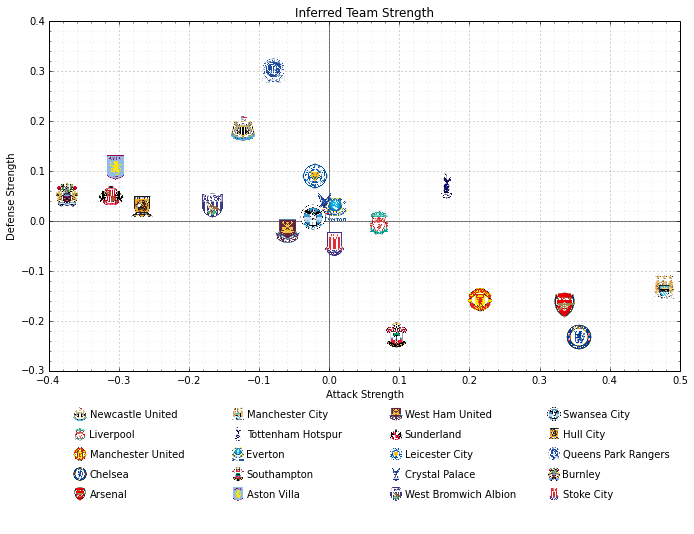

In [377]:
import matplotlib.gridspec as gridspec
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib._png import read_png

trace = traces[37]

atts = trace['atts']
atts = np.swapaxes(atts,0,1)
mean_atts = [n.mean() for n in atts]

defs = trace['defs']
defs = np.swapaxes(defs,0,1)
mean_defs = [n.mean() for n in defs]

lv = pd.DataFrame(data=teams, columns=['team'])
lv['attack'] = mean_atts
lv['defense'] = mean_defs

gs = gridspec.GridSpec(2, 1, width_ratios=[1,1], height_ratios=[3.5,1])

fig = plt.figure(figsize=(18.5, 7.5))

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])

ax1.axis([-0.4, 0.5, -0.3, 0.4])

ax1.set_xticks(np.arange(-0.4, 0.55, 0.1))
ax1.set_xticks(np.arange(-0.4, 0.5, 0.02), minor=True)
ax1.set_yticks(np.arange(-0.3, 0.45, 0.1))
ax1.set_yticks(np.arange(-0.3, 0.4, 0.02), minor=True)                                                     

ax1.yaxis.grid(True, which='major', alpha=0.5)
ax1.yaxis.grid(True, which='minor', alpha=0.2)
ax1.xaxis.grid(True, which='major', alpha=0.5)
ax1.xaxis.grid(True, which='minor', alpha=0.2)

ax1.axhline(0, color='grey')
ax1.axvline(0, color='grey')

ax1.set_xlabel('Attack Strength')
ax1.set_ylabel('Defense Strength')
ax1.set_title("Inferred Team Strength")

for k,v in enumerate(lv.values):
    x = lv.iloc[k]['attack']
    y = lv.iloc[k]['defense']
    
    team = lv.iloc[k]['team'].lower().replace(" ", "_")
    
    ax1.scatter(x,y)
    
    file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
    icon = read_png(file)
    imagebox = OffsetImage(icon, zoom=0.10)

    ab = AnnotationBbox(imagebox, (x,y), frameon=False)
    ax1.add_artist(ab)

ax2.axis('off')
ax2.axis([0, 1, 0.5, 1])

for k,v in enumerate(lv.values):
    if (k <= 4):
        x = 0
        y = k * 0.1
    elif (k <= 9):
        x = 0.25
        y = (k-5)*0.1
    elif (k <= 14):
        x = 0.5
        y = (k-10)*0.1
    else:
        x = 0.75
        y = (k-15)*0.1
    
    team = lv.iloc[k]['team'].lower().replace(" ", "_")
    team_name = lv.iloc[k]['team']
    
    file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
    icon = read_png(file)
    imagebox = OffsetImage(icon, zoom=0.055)

    crest = AnnotationBbox(imagebox, (x+0.05,y+0.015+0.58), frameon=False)
    ax2.add_artist(crest)
    ax2.annotate(team_name, xy=(x+0.015+0.05,y+0.58))

fig.tight_layout()

plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/team-parameters.pdf",bbox_inches='tight')
    
plt.show()

## Plot evolution of parameter estimates, when not modelled explicitely

In [478]:
traces[0]

<MultiTrace: 1 chains, 10000 iterations, 10 variables>

In [513]:
# Calculate 95% CI
def mci(samples):
    lb = np.percentile(samples, 2.5, axis=1)
    mn = np.mean(samples, axis=1)
    md = np.percentile(samples, 50, axis=1)
    ub = np.percentile(samples, 97.5, axis=1)
    return md, mn, lb, ub

In [514]:
att_mcis = []
def_mcis = []

for i in range(0,38):
    t = traces[i]

    atts = t['atts']
    atts = np.swapaxes(atts,0,1)
    defs = t['defs']
    defs = np.swapaxes(defs,0,1)

    att_mcis.append( mci(atts) )
    def_mcis.append( mci(defs) )
    
att_mcis = np.swapaxes(np.array(att_mcis),0,2)
def_mcis = np.swapaxes(np.array(def_mcis),0,2)

xs = range(1,38+1)

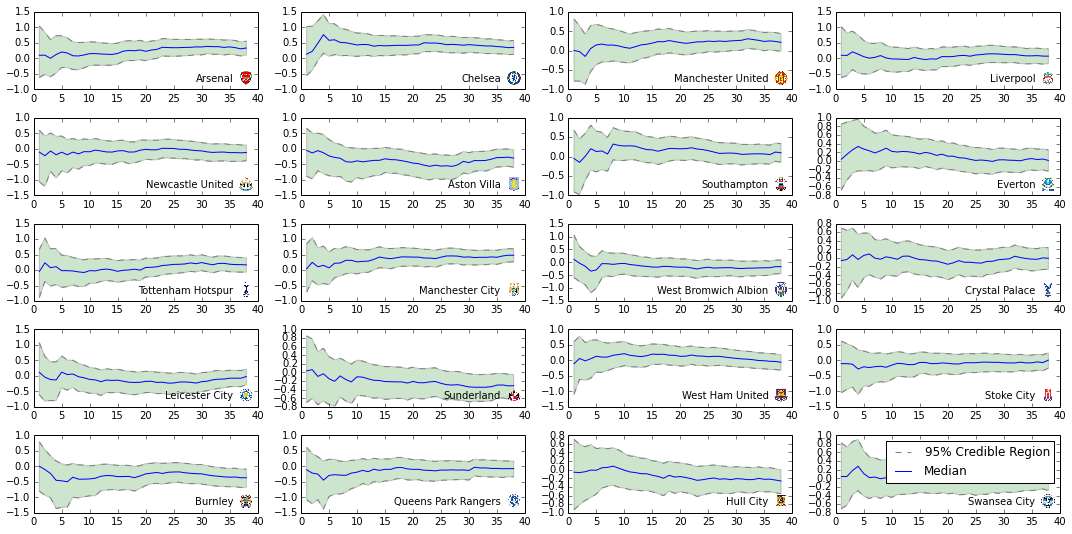

In [570]:
fig, ax = plt.subplots(5,4,figsize=(15,7.5))
c = 0
for i in range(0,5):
    for j in range(0,4):
        md = att_mcis[c][0]
        mn = att_mcis[c][1]
        lb = att_mcis[c][2]
        ub = att_mcis[c][3]

        ax[i][j].plot(xs, lb, '--', color='0.5', label='95% Credible Region')
        ax[i][j].plot(xs, md, marker=None, markersize=10, label='Median')
#         ax[i][j].plot(xs, mn, marker=None, markersize=10, label='Mean')
        ax[i][j].plot(xs, ub, '--', color='0.5')
        ax[i][j].fill_between(xs, lb, ub, facecolor='green', alpha=0.2)
        
        team = lv.iloc[c]['team'].lower().replace(" ", "_")
        team_name = lv.iloc[c]['team']

        file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
        icon = read_png(file)
        imagebox = OffsetImage(icon, zoom=0.055)

        crest = AnnotationBbox(imagebox, xycoords='axes fraction', xy=(1-0.05,0.15), frameon=False)
        ax[i][j].add_artist(crest)
        ax[i][j].annotate(teams["team"][c], xycoords='axes fraction', xy=(1-0.110,0.075),
                         horizontalalignment='right', verticalalignment='bottom')
        
        c += 1
#     ax[i].set_ylabel('Attack Strength')
#     ax[i].set_xlabel('Fixture Weeks of Season 2014/15')
#     ax[i].set_title("Team Strength Evolution")

fig.tight_layout()
plt.legend()
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/evolution-uncertainty-static-atts.pdf",bbox_inches='tight')
plt.show()

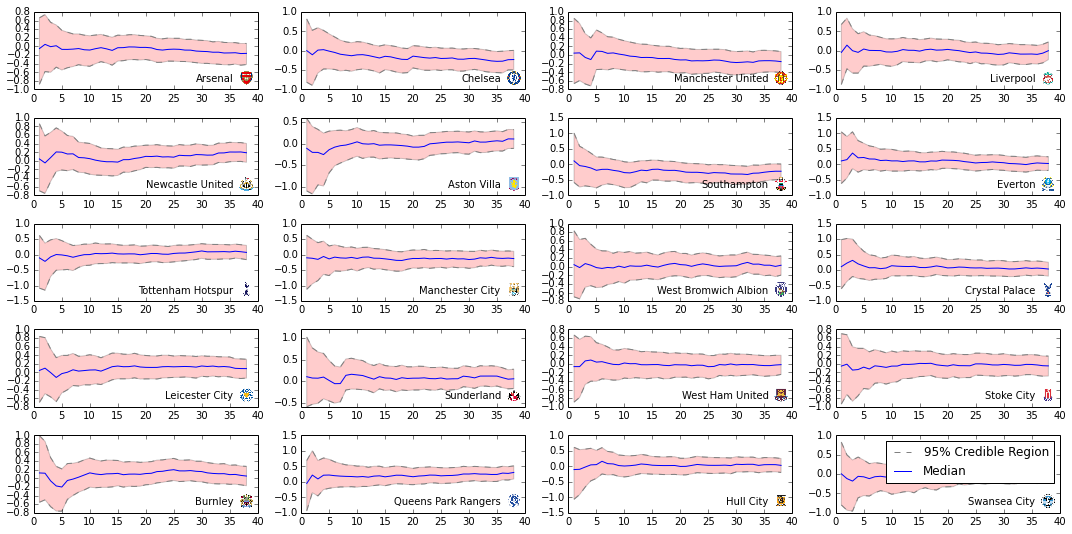

In [571]:
fig, ax = plt.subplots(5,4,figsize=(15,7.5))
c = 0
for i in range(0,5):
    for j in range(0,4):
        md = def_mcis[c][0]
        mn = def_mcis[c][1]
        lb = def_mcis[c][2]
        ub = def_mcis[c][3]

        ax[i][j].plot(xs, lb, '--', color='0.5', label='95% Credible Region')
        ax[i][j].plot(xs, md, marker=None, markersize=10, label='Median')
#         ax[i][j].plot(xs, mn, marker=None, markersize=10, label='Mean')
        ax[i][j].plot(xs, ub, '--', color='0.5')
        ax[i][j].fill_between(xs, lb, ub, facecolor='red', alpha=0.2)
        
        team = lv.iloc[c]['team'].lower().replace(" ", "_")
        team_name = lv.iloc[c]['team']

        file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
        icon = read_png(file)
        imagebox = OffsetImage(icon, zoom=0.055)

        crest = AnnotationBbox(imagebox, xycoords='axes fraction', xy=(1-0.05,0.15), frameon=False)
        ax[i][j].add_artist(crest)
        ax[i][j].annotate(teams["team"][c], xycoords='axes fraction', xy=(1-0.110,0.075),
                         horizontalalignment='right', verticalalignment='bottom')
        
        c += 1
#     ax[i].set_ylabel('Attack Strength')
#     ax[i].set_xlabel('Fixture Weeks of Season 2014/15')
#     ax[i].set_title("Team Strength Evolution")

fig.tight_layout()
plt.legend()
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/evolution-uncertainty-static-defs.pdf",bbox_inches='tight')
plt.show()

## Correlation btw. latent parameters

In [243]:
t = traces[-1] # Use trace which is conditioned on all variables p(theta|x)
atts = t['atts']
atts = np.swapaxes(atts,0,1)
defs = t['defs']
defs = np.swapaxes(defs,0,1)
home = t['home']
intercept = t['intercept']
tau_att = t['tau_att']
tau_def = t['tau_def']

# Analyse correlation of model parameters for Arsenal

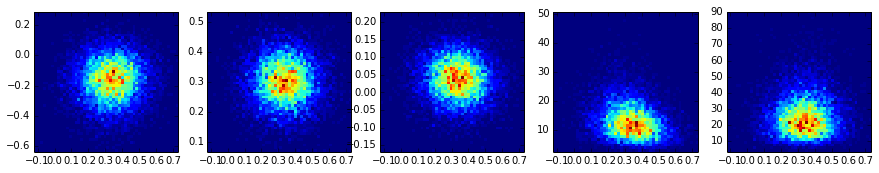

In [282]:
fig, ax = plt.subplots(1,5,figsize=(15,2.5))

ax[0].hist2d(atts[0], defs[0], bins=50)
ax[1].hist2d(atts[0], home, bins=50)
ax[2].hist2d(atts[0], intercept, bins=50)
ax[3].hist2d(atts[0], tau_att, bins=50)
ax[4].hist2d(atts[0], tau_def, bins=50)

plt.show()